# Direct Stiffness Method and Linear Buckling Analysis

The direct stiffness method is a displacement-based structural analysis method; that is, the primary unkowns are displacement-like quantities i.e. translations and rotations. Force-like quantities are obtained in post-processing. For a linear problem, this method results in a system of linear algebraic equations.

## Example Problem 1: Frame with rectangular cross-sections

In the cell below, you import the solver to this notebook, and initiate the process of defining all the relevant geometric and material properties of the structure.

In [1]:
# --- Import the solver from /src directiory (Don't touch!) ---
import sys
import os
project_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(project_path, "src"))
from direct_stiffness_method.direct_stiffness_method import Structure, BoundaryConditions, Solver, PostProcessing, BucklingAnalysis, PlotResults

import numpy as np

# Define nodes and their coordinates [#, x, y, z]
nodes = {
    0: [0, 0.0, 0.0, 10.0],
    1: [1, 15.0, 0.0, 10.0],
    2: [2, 15.0, 0.0, 0.0]
}

# Define the connectivity [node i, node j]
elements = [
    [0, 1],
    [1, 2]
]

# Elements properties
element_properties = {
    0: {"b": 0.5, "h": 1.0, "E": 1000, "nu": 0.3},
    
    1: {"b": 1.0, "h": 0.5, "E": 1000, "nu": 0.3}
}


# Run class
structure = Structure(nodes, elements, element_properties)

In the cell below, you get a summary for the properties you entered.

In [3]:
# Display summary for the geometric and material properties per element
structure.display_summary()

--- Structure Summary ---
Number of Elements: 2
Elasticity Modulus (E):
  Element 0: 1000
  Element 1: 1000

Poisson's Ratio (nu):
  Element 0: 0.3
  Element 1: 0.3

--- Element Properties ---
Element 1:
  Length: 15.0000
  Area (A): 0.5000
  Moment of Inertia Iy: 0.0104
  Moment of Inertia Iz: 0.0417
  Polar Moment of Inertia J: 0.0521
  Node 1: (0.0, 0.0, 10.0), Node 2: (15.0, 0.0, 10.0)

Element 2:
  Length: 10.0000
  Area (A): 0.5000
  Moment of Inertia Iy: 0.0417
  Moment of Inertia Iz: 0.0104
  Polar Moment of Inertia J: 0.0521
  Node 1: (15.0, 0.0, 10.0), Node 2: (15.0, 0.0, 0.0)

--- Connectivity Matrix ---
Element 1: [0 1]
Element 2: [1 2]

Global Node Numbering:
Global Node 0: Coordinates (0.0, 0.0, 10.0)
Global Node 1: Coordinates (15.0, 0.0, 10.0)
Global Node 2: Coordinates (15.0, 0.0, 0.0)

* * * * * * * * * *


In the below cell, you define the loads and the boundary conditions.

In [6]:
# Define externally applied loads [#, Fx, Fy, Fz, Mx, My, Mz]

loads = {
    0: [0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    1: [1, 0.1, 0.05, -0.07, 0.05, -0.1, 0.25],
    2: [2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
}

# Define supports [#, ux, uy, uz, theta_x, theta_y, theta_z]
# 1 means constrained dof
# 0 means free dof

supports = {
    0: [0, 1, 1, 1, 1, 1, 1],
    1: [1, 0, 0, 0, 0, 0, 0],
    2: [2, 1, 1, 1, 0, 0, 0]
}

bc = BoundaryConditions(loads, supports)

In [9]:
# Compute and print the external load vector
bc.compute_global_load_vector()
bc.print_global_load_vector()

# Summarize and print boundary conditions
bc.summarize_boundary_conditions()


--- External Load Vector ---
[[ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.1 ]
 [ 0.05]
 [-0.07]
 [ 0.05]
 [-0.1 ]
 [ 0.25]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]]

--- Boundary Conditions ---
Node 0: Constraints [1, 1, 1, 1, 1, 1]
Node 1: Constraints [0, 0, 0, 0, 0, 0]
Node 2: Constraints [1, 1, 1, 0, 0, 0]


Now, in the below cell, the geometric boundary conditions are applied, then the problem is solved.

In [12]:
solver = Solver(structure, bc)
U_global = solver.solve()
R_global = solver.compute_reactions(U_global)


--- Computed Displacements ---
[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 2.84049953e-03]
 [ 1.43541318e+00]
 [-1.30609178e-03]
 [-1.26072079e-01]
 [-1.67293339e-02]
 [ 1.66041318e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.52275937e-01]
 [ 8.79074190e-03]
 [ 1.66041318e-01]]

--- Computed Reactions ---
[[-0.09468332]
 [-0.02816345]
 [ 0.00469541]
 [ 0.16836549]
 [-0.02359799]
 [-0.67245177]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.00531668]
 [-0.02183655]
 [ 0.06530459]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]


Now, we post-process by calculating the internal forces per element in local coordinates.

In [15]:
# Create post-processing object
post_processing = PostProcessing(structure, U_global)

# Compute internal forces
post_processing.compute_internal_forces()

# Print internal forces
post_processing.print_internal_forces()


--- Internal Forces in Local Coordinates ---
Element 1:
[-0.09468332 -0.02816345  0.00469541  0.16836549 -0.02359799 -0.67245177
  0.09468332  0.02816345 -0.00469541 -0.16836549 -0.04683318  0.25      ]
Element 2:
[ 6.53045890e-02 -5.31668247e-03  2.18365490e-02 -1.02529531e-17
 -2.18365490e-01 -5.31668247e-02 -6.53045890e-02  5.31668247e-03
 -2.18365490e-02  1.02529531e-17  2.86968227e-16  1.15548791e-18]


Now, we plot the undeformed vs deformed configurations.

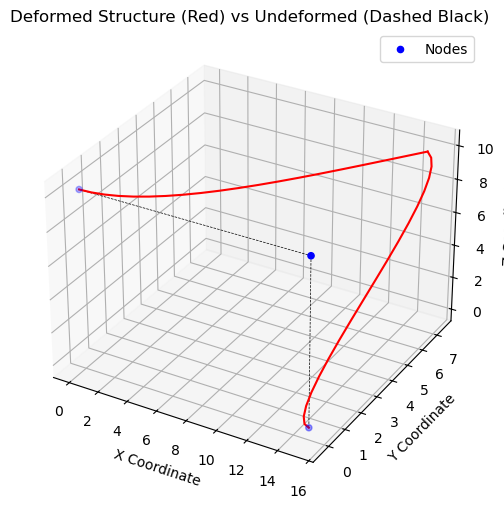

In [18]:
# Create the PlotResults object
plotter = PlotResults(structure, U_global, scale=5)

# Plot the deformed shape
plotter.plot_deformed_shape()


## Example Problem 2: Frame with circular cross-sections

In the cell below, you import the solver to this notebook, and initiate the process of defining all the relevant geometric and material properties of the structure.

In [22]:
# --- Import the solver from /src directiory (Don't touch!) ---
import sys
import os
project_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(project_path, "src"))
from direct_stiffness_method.direct_stiffness_method import Structure, BoundaryConditions, Solver

import numpy as np

# Define nodes and their coordinates [#, x, y, z]
nodes = {
    0: [0, 0.0, 0.0, 0.0],
    1: [1, -5.0, 1.0, 10.0],
    2: [2, -1.0, 5.0, 13.0],
    3: [3, -3.0, 7.0, 11.0],
    4: [4, 6.0, 9.0, 5.0]
}

# Define the connectivity [node i, node j]
elements = [
    [0, 1],
    [1, 2],
    [2, 3],
    [2, 4]
]

# Elements properties
element_properties = {
    0: {"r": 1.0, "E": 500, "nu": 0.3},
    
    1: {"r": 1.0, "E": 500, "nu": 0.3},

    2: {"r": 1.0, "E": 500, "nu": 0.3},
    
    3: {"r": 1.0, "E": 500, "nu": 0.3},

}

# Run class
structure = Structure(nodes, elements, element_properties)

In the cell below, you get a summary for the properties you entered.

In [25]:
# Display summary for the geometric and material properties per element
structure.display_summary()

--- Structure Summary ---
Number of Elements: 4
Elasticity Modulus (E):
  Element 0: 500
  Element 1: 500
  Element 2: 500
  Element 3: 500

Poisson's Ratio (nu):
  Element 0: 0.3
  Element 1: 0.3
  Element 2: 0.3
  Element 3: 0.3

--- Element Properties ---
Element 1:
  Length: 11.2250
  Area (A): 3.1416
  Moment of Inertia Iy: 0.7854
  Moment of Inertia Iz: 0.7854
  Polar Moment of Inertia J: 1.5708
  Node 1: (0.0, 0.0, 0.0), Node 2: (-5.0, 1.0, 10.0)

Element 2:
  Length: 6.4031
  Area (A): 3.1416
  Moment of Inertia Iy: 0.7854
  Moment of Inertia Iz: 0.7854
  Polar Moment of Inertia J: 1.5708
  Node 1: (-5.0, 1.0, 10.0), Node 2: (-1.0, 5.0, 13.0)

Element 3:
  Length: 3.4641
  Area (A): 3.1416
  Moment of Inertia Iy: 0.7854
  Moment of Inertia Iz: 0.7854
  Polar Moment of Inertia J: 1.5708
  Node 1: (-1.0, 5.0, 13.0), Node 2: (-3.0, 7.0, 11.0)

Element 4:
  Length: 11.3578
  Area (A): 3.1416
  Moment of Inertia Iy: 0.7854
  Moment of Inertia Iz: 0.7854
  Polar Moment of Inertia J: 

In the below cell, you define the loads and the boundary conditions.

In [28]:
# Define externally applied loads [#, Fx, Fy, Fz, Mx, My, Mz]

loads = {
    0: [0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    1: [1, 0.1, -0.05, -0.075, 0.0, 0.0, 0.0],
    2: [2, 0.0, 0.0, 0.0, 0.5, -0.1, 0.3],
    3: [3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    4: [4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
}

# Define supports [#, ux, uy, uz, theta_x, theta_y, theta_z]
# 1 means constrained dof
# 0 means free dof

supports = {
    0: [0, 0, 0, 1, 0, 0, 0],
    1: [1, 0, 0, 0, 0, 0, 0],
    2: [2, 0, 0, 0, 0, 0, 0],
    3: [2, 1, 1, 1, 1, 1, 1],
    4: [2, 1, 1, 1, 0, 0, 0]    
}

bc = BoundaryConditions(loads, supports)

In [30]:
# Compute and print the external load vector
bc.compute_global_load_vector()
bc.print_global_load_vector()

# Summarize and print boundary conditions
bc.summarize_boundary_conditions()


--- External Load Vector ---
[[ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.1  ]
 [-0.05 ]
 [-0.075]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.5  ]
 [-0.1  ]
 [ 0.3  ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]]

--- Boundary Conditions ---
Node 0: Constraints [0, 0, 1, 0, 0, 0]
Node 1: Constraints [0, 0, 0, 0, 0, 0]
Node 2: Constraints [0, 0, 0, 0, 0, 0]
Node 3: Constraints [1, 1, 1, 1, 1, 1]
Node 4: Constraints [1, 1, 1, 0, 0, 0]


Now, in the below cell, the geometric boundary conditions are applied, then the problem is solved.

In [33]:
solver = Solver(structure, bc)
U_global = solver.solve()
R_global = solver.compute_reactions(U_global)


--- Computed Displacements ---
[[ 0.16297422]
 [ 0.06753731]
 [ 0.        ]
 [ 0.0038603 ]
 [-0.00977672]
 [ 0.00997704]
 [ 0.05683823]
 [-0.02127261]
 [-0.04423469]
 [ 0.00395566]
 [-0.00929992]
 [ 0.00997704]
 [ 0.00104443]
 [ 0.00109052]
 [ 0.00034632]
 [ 0.00313556]
 [-0.0040055 ]
 [ 0.00514273]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.00455166]
 [ 0.00049019]
 [ 0.00066426]]

--- Computed Reactions ---
[[ 0.        ]
 [ 0.        ]
 [ 0.0066722 ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.02351271]
 [ 0.13794825]
 [ 0.02532498]
 [-0.41161075]
 [ 0.29811823]
 [-0.36144034]
 [-0.07648729]
 [-0.08794825]
 [ 0.04300282]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]


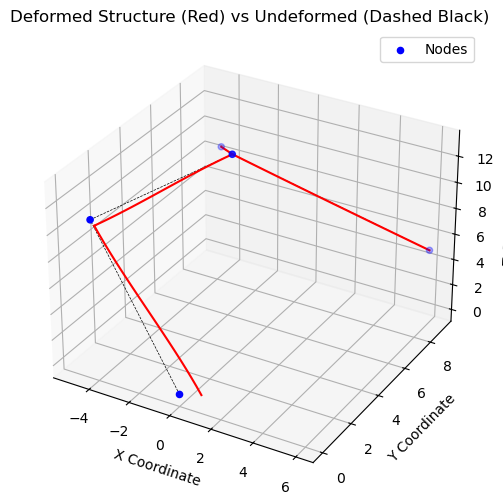

In [35]:
# Create the PlotResults object
plotter = PlotResults(structure, U_global, scale=5)

# Plot the deformed shape
plotter.plot_deformed_shape()

## Example Problem 3: Euler Buckling Analysis

In [38]:
# --- Import the solver from /src directiory (Don't touch!) ---
import sys
import os
project_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(project_path, "src"))
from direct_stiffness_method.direct_stiffness_method import Structure, BoundaryConditions, Solver, PostProcessing, BucklingAnalysis

import numpy as np

# Define nodes and their coordinates [#, x, y, z]
nodes = {
    0: [0, 0.0, 0.0, 0.0],
    1: [1, 30.0, 40.0, 0.0],
}

# Define the connectivity [node i, node j]
elements = [
    [0, 1]
]

# Elements properties
element_properties = {
    0: {"r": 1.0, "E": 1000, "nu": 0.3},
    
}

# Run class
structure = Structure(nodes, elements, element_properties)

In the cell below, you get a summary for the properties you entered.

In [41]:
# Display summary for the geometric and material properties per element
structure.display_summary()

--- Structure Summary ---
Number of Elements: 1
Elasticity Modulus (E):
  Element 0: 1000

Poisson's Ratio (nu):
  Element 0: 0.3

--- Element Properties ---
Element 1:
  Length: 50.0000
  Area (A): 3.1416
  Moment of Inertia Iy: 0.7854
  Moment of Inertia Iz: 0.7854
  Polar Moment of Inertia J: 1.5708
  Node 1: (0.0, 0.0, 0.0), Node 2: (30.0, 40.0, 0.0)

--- Connectivity Matrix ---
Element 1: [0 1]

Global Node Numbering:
Global Node 0: Coordinates (0.0, 0.0, 0.0)
Global Node 1: Coordinates (30.0, 40.0, 0.0)

* * * * * * * * * *


In the below cell, you define the loads and the boundary conditions.

In [44]:
# Define externally applied loads [#, Fx, Fy, Fz, Mx, My, Mz]

loads = {
    0: [0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    1: [1, -0.6, -0.8, 0.0, 0.0, 0.0, 0.0],
}

# Define supports [#, ux, uy, uz, theta_x, theta_y, theta_z]
# 1 means constrained dof
# 0 means free dof

supports = {
    0: [0, 1, 1, 1, 1, 1, 1],
    1: [1, 0, 0, 0, 0, 0, 0]
}

bc = BoundaryConditions(loads, supports)

In [46]:
# Compute and print the external load vector
bc.compute_global_load_vector()
bc.print_global_load_vector()

# Summarize and print boundary conditions
bc.summarize_boundary_conditions()


--- External Load Vector ---
[[ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [-0.6]
 [-0.8]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]]

--- Boundary Conditions ---
Node 0: Constraints [1, 1, 1, 1, 1, 1]
Node 1: Constraints [0, 0, 0, 0, 0, 0]


Now, in the below cell, the geometric boundary conditions are applied, then the problem is solved.

In [49]:
solver = Solver(structure, bc)
U_global = solver.solve()
R_global = solver.compute_reactions(U_global)


--- Computed Displacements ---
[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-9.54929659e-03]
 [-1.27323954e-02]
 [-0.00000000e+00]
 [ 0.00000000e+00]
 [-0.00000000e+00]
 [-4.66816243e-17]]

--- Computed Reactions ---
[[6.00000000e-01]
 [8.00000000e-01]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.47104551e-15]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]]


Now, we post-process by calculating the internal forces per element in local coordinates.

In [52]:
# Create post-processing object
post_processing = PostProcessing(structure, U_global)

# Compute internal forces
post_processing.compute_internal_forces()

# Print internal forces
post_processing.print_internal_forces()


--- Internal Forces in Local Coordinates ---
Element 1:
[ 1.00000000e+00  2.93957853e-17  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.46816787e-15 -1.00000000e+00 -2.93957853e-17
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.62139119e-18]


Calculate the geometric stiffness matrix

In [55]:
# Create BucklingAnalysis object
buckling_analysis = BucklingAnalysis(structure, solver, post_processing)

# # Compute and print the critical load
# P_critical = buckling_analysis.calculate_critical_load(solver)
# print(f"Critical Load (P_critical): {P_critical}")

P_critical, mode_shape = buckling_analysis.calculate_critical_load(solver)

print(f"Critical Load (P_critical): {P_critical}")
print("Eigenvector (Mode Shape), with 0's at constrained dofs:")
print(mode_shape)

Critical Load (P_critical): 0.7809879011059857
Eigenvector (Mode Shape), with 0's at constrained dofs:
[ 0.          0.          0.          0.          0.          0.
 -0.         -0.          0.99950879  0.02507191 -0.01880393 -0.        ]


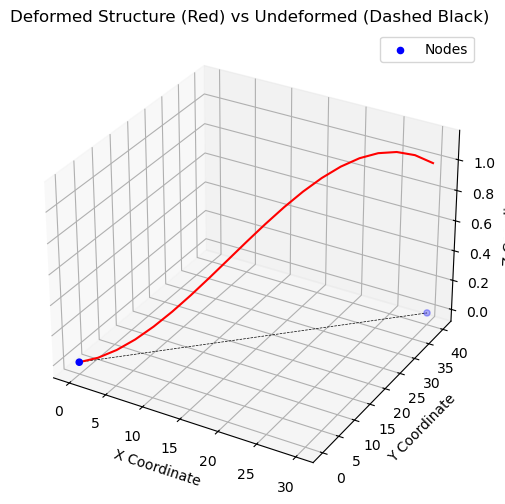

In [57]:
# Create the PlotResults object
plotter = PlotResults(structure, mode_shape, scale=1)

# Plot the deformed shape
plotter.plot_deformed_shape()

## Example Problem 4: Frame Buckling

In the cell below, you import the solver to this notebook, and initiate the process of defining all the relevant geometric and material properties of the structure.

In [61]:
# --- Import the solver from /src directiory (Don't touch!) ---
import sys
import os
project_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(project_path, "src"))
from direct_stiffness_method.direct_stiffness_method import Structure, BoundaryConditions, Solver, PostProcessing, BucklingAnalysis, PlotResults

import numpy as np

# Define nodes and their coordinates [#, x, y, z]
nodes = {
    0: [0, 0.0, 0.0, 0.0],
    1: [1, 10.0, 0.0, 0.0],
    2: [2, 10.0, 20.0, 0.0],
    3: [3, 0.0, 20.0, 0.0],
    4: [4, 0.0, 0.0, 25.0],
    5: [5, 10.0, 0.0, 25.0],
    6: [6, 10.0, 20.0, 25.0],
    7: [7, 0.0, 20.0, 25.0],
   
}

# Define the connectivity [node i, node j]
elements = [
    [0, 4],
    [1,5],
    [2, 6],
    [3, 7],
    [4, 5],
    [5, 6],
    [6, 7],
    [4, 7]
]

# Elements properties
element_properties = {
    0: {"r": 0.5, "E": 500, "nu": 0.3},
    1: {"r": 0.5, "E": 500, "nu": 0.3},
    2: {"r": 0.5, "E": 500, "nu": 0.3},
    3: {"r": 0.5, "E": 500, "nu": 0.3},
    4: {"r": 0.5, "E": 500, "nu": 0.3},
    5: {"r": 0.5, "E": 500, "nu": 0.3},
    6: {"r": 0.5, "E": 500, "nu": 0.3},
    7: {"r": 0.5, "E": 500, "nu": 0.3},
}

# Run class
structure = Structure(nodes, elements, element_properties)

In the cell below, you get a summary for the properties you entered.

In [64]:
# Display summary for the geometric and material properties per element
structure.display_summary()

--- Structure Summary ---
Number of Elements: 8
Elasticity Modulus (E):
  Element 0: 500
  Element 1: 500
  Element 2: 500
  Element 3: 500
  Element 4: 500
  Element 5: 500
  Element 6: 500
  Element 7: 500

Poisson's Ratio (nu):
  Element 0: 0.3
  Element 1: 0.3
  Element 2: 0.3
  Element 3: 0.3
  Element 4: 0.3
  Element 5: 0.3
  Element 6: 0.3
  Element 7: 0.3

--- Element Properties ---
Element 1:
  Length: 25.0000
  Area (A): 0.7854
  Moment of Inertia Iy: 0.0491
  Moment of Inertia Iz: 0.0491
  Polar Moment of Inertia J: 0.0982
  Node 1: (0.0, 0.0, 0.0), Node 2: (0.0, 0.0, 25.0)

Element 2:
  Length: 25.0000
  Area (A): 0.7854
  Moment of Inertia Iy: 0.0491
  Moment of Inertia Iz: 0.0491
  Polar Moment of Inertia J: 0.0982
  Node 1: (10.0, 0.0, 0.0), Node 2: (10.0, 0.0, 25.0)

Element 3:
  Length: 25.0000
  Area (A): 0.7854
  Moment of Inertia Iy: 0.0491
  Moment of Inertia Iz: 0.0491
  Polar Moment of Inertia J: 0.0982
  Node 1: (10.0, 20.0, 0.0), Node 2: (10.0, 20.0, 25.0)

El

In the below cell, you define the loads and the boundary conditions.

In [67]:
# Define externally applied loads [#, Fx, Fy, Fz, Mx, My, Mz]

loads = {
    0: [0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    1: [1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    2: [2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    3: [3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    4: [4, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0],
    5: [5, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0],
    6: [6, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0],
    7: [7, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0],
    
}

# Define supports [#, ux, uy, uz, theta_x, theta_y, theta_z]
# 1 means constrained dof
# 0 means free dof

supports = {
    0: [0, 1, 1, 1, 1, 1, 1],
    1: [1, 1, 1, 1, 1, 1, 1],
    2: [2, 1, 1, 1, 1, 1, 1],
    3: [3, 1, 1, 1, 1, 1, 1],
    4: [4, 0, 0, 0, 0, 0, 0],
    5: [5, 0, 0, 0, 0, 0, 0],
    6: [6, 0, 0, 0, 0, 0, 0],
    7: [7, 0, 0, 0, 0, 0, 0]

}

bc = BoundaryConditions(loads, supports)

In [69]:
# Compute and print the external load vector
bc.compute_global_load_vector()
bc.print_global_load_vector()

# Summarize and print boundary conditions
bc.summarize_boundary_conditions()


--- External Load Vector ---
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-1.]
 [ 0.]
 [ 0.]
 [ 0.]]

--- Boundary Conditions ---
Node 0: Constraints [1, 1, 1, 1, 1, 1]
Node 1: Constraints [1, 1, 1, 1, 1, 1]
Node 2: Constraints [1, 1, 1, 1, 1, 1]
Node 3: Constraints [1, 1, 1, 1, 1, 1]
Node 4: Constraints [0, 0, 0, 0, 0, 0]
Node 5: Constraints [0, 0, 0, 0, 0, 0]
Node 6: Constraints [0, 0, 0, 0, 0, 0]
Node 7: Constraints [0, 0, 0, 0, 0, 0]


Now, in the below cell, the geometric boundary conditions are applied, then the problem is solved.

In [72]:
solver = Solver(structure, bc)
U_global = solver.solve()
R_global = solver.compute_reactions(U_global)


--- Computed Displacements ---
[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-9.09183342e-17]
 [ 2.13096253e-17]
 [-6.36619772e-02]
 [-7.73735392e-19]
 [-1.29494786e-18]
 [-5.84852125e-19]
 [-9.09580551e-17]
 [ 1.61910137e-17]
 [-6.36619772e-02]
 [-1.45177182e-18]
 [-1.08291858e-18]
 [-5.84938819e-19]
 [-7.51580169e-17]
 [ 1.62000053e-17]
 [-6.36619772e-02]
 [-1.81599663e-18]
 [ 9.65664386e-19]
 [-5.83953775e-19]
 [-7.51255294e-17]
 [ 2.13098425e-17]
 [-6.36619772e-02]
 [-1.22358304e-18]
 [ 4.70235817e-20]
 [-5.83784235e-19]]

--- Computed Reactions ---
[[ 1.40865532e-18]
 [-2.193

Now, we post-process by calculating the internal forces per element in local coordinates.

In [75]:
# Create post-processing object
post_processing = PostProcessing(structure, U_global)

# Compute internal forces
post_processing.compute_internal_forces()

# Print internal forces
post_processing.print_internal_forces()


--- Internal Forces in Local Coordinates ---
Element 1:
[ 1.00000000e+00  1.40865532e-18 -2.19369866e-19  4.41674793e-19
  3.50173627e-18  1.88795036e-17 -1.00000000e+00 -1.40865532e-18
  2.19369866e-19 -4.41674793e-19  1.98251038e-18  1.63368795e-17]
Element 2:
[ 1.00000000e+00  1.45936227e-18  3.68722580e-20  4.41740264e-19
  9.64370426e-19  1.93051812e-17 -1.00000000e+00 -1.45936227e-18
 -3.68722580e-20 -4.41740264e-19 -1.88617688e-18  1.71788755e-17]
Element 3:
[ 1.00000000e+00  1.64422455e-18  1.22521219e-19  4.40996368e-19
  2.51335286e-19  1.96047681e-17 -1.00000000e+00 -1.64422455e-18
 -1.22521219e-19 -4.40996368e-19 -3.31436576e-18  2.15008457e-17]
Element 4:
[ 1.00000000e+00  1.42716254e-18 -1.13381107e-19  4.40868332e-19
  2.61851368e-18  1.77933664e-17 -1.00000000e+00 -1.42716254e-18
  1.13381107e-19 -4.40868332e-19  2.16013998e-19  1.78856970e-17]
Element 5:
[ 1.55983617e-18 -2.15103820e-19  1.89941197e-18  1.28011674e-18
  3.69816846e-18 -1.07530632e-18 -1.55983617e-18  

Calculate the geometric stiffness matrix

In [78]:
# Create BucklingAnalysis object
buckling_analysis = BucklingAnalysis(structure, solver, post_processing)

# # Compute and print the critical load
# P_critical = buckling_analysis.calculate_critical_load(solver)
# print(f"Critical Load (P_critical): {P_critical}")

P_critical, mode_shape = buckling_analysis.calculate_critical_load(solver)

print(f"Critical Load (P_critical): {P_critical}")
print("Eigenvector (Mode Shape), with 0's at constrained dofs:")
print(mode_shape)

Critical Load (P_critical): 0.3072145243024915
Eigenvector (Mode Shape), with 0's at constrained dofs:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.70040462e-13  4.99899553e-01  4.67436396e-04 -1.00109189e-02
  8.99215473e-15 -6.06919924e-16  3.70037882e-13  4.99899553e-01
  4.67436396e-04 -1.00109189e-02  3.65879564e-15 -3.22473246e-16
  3.71350747e-13  4.99899553e-01 -4.67436396e-04 -1.00109189e-02
  5.32102621e-15 -4.62959840e-16  3.71371140e-13  4.99899553e-01
 -4.67436396e-04 -1.00109189e-02  3.21793142e-15 -1.98376632e-16]


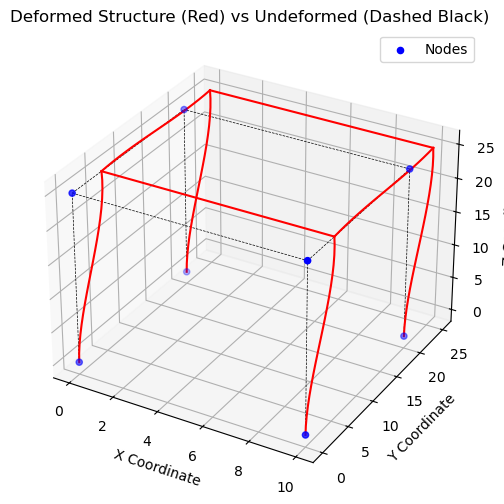

In [80]:
# Create the PlotResults object
plotter = PlotResults(structure, mode_shape, scale=10)

# Plot the deformed shape
plotter.plot_deformed_shape()